lambda max of A: 11.375529656810523
Filter coefs: [0.29399155 0.38311672 0.32289173]
lambda max of H: 46.435200314575944
Fts: 48 Max lambda JJ: 967.48785
Fts: 48 Max Sigmas W: [1.8102512 1.7309492 1.6511846 1.6158909]
Fts: 48 Norm W: 6.938876
Fts: 150 Max lambda JJ: 995.0082
Fts: 150 Max Sigmas W: [2.4796221 2.359932  2.2839518 2.229396 ]
Fts: 150 Norm W: 12.170378
Fts: 640 Max lambda JJ: 1000.74634
Fts: 640 Max Sigmas W: [4.178562  4.1480184 4.0837636 3.960878 ]
Fts: 640 Norm W: 25.391546
Fts: 5000 Max lambda JJ: 970.72974
Fts: 5000 Max Sigmas W: [9.840942  9.757519  9.695882  9.6286125]
Fts: 5000 Norm W: 70.63892
Jacobians done in 0.041012307008107506 minnutes


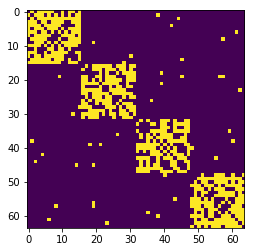

In [11]:
import sys
import copy
import time

import numpy as np
import torch
import matplotlib.pyplot as plt

sys.path.insert(0, '..')
from graph_deep_decoder import datasets as ds
from graph_deep_decoder import utils
from graph_deep_decoder.architecture import GraphDecoder
from graph_deep_decoder.model import Model

SEED = 0
torch.manual_seed(SEED)
np.random.seed(SEED)

# Graph parameters
Gs = {}
Gs['type'] = ds.SBM
Gs['N'] = 64
Gs['k'] = 4
Gs['type_z'] = ds.CONT
Gs['p'] = 0.7
Gs['q'] = 0.015

# Signal parameters
K = 3
n_signals = 100
n_p = 0.1

# Model parameters
epochs = 1000
lr = 0.001

# Create graph
G = ds.create_graph(Gs, SEED)
A = G.W.todense()
Lambda_A, _ = utils.ordered_eig(A)
print('lambda max of A:', Lambda_A[0])
plt.figure()
plt.imshow(A)


# Create filter H and decoder
hs = np.random.rand(K)
hs /= np.sum(hs)
print('Filter coefs:', hs)
x_dw = ds.DiffusedWhiteGS(G, ds.NonLin.NONE, K, coefs=hs)
H = x_dw.H
Lambda_H, _ = utils.ordered_eig(H)
print('lambda max of H:', Lambda_H[0])

# Prepare experiments
exps = []
fts = [48, 150, 640]
params = [1, 2, 4, 8, 16, 32, 64]

# Compute Jacobians and eig dec
for ft in fts:
    start_time = time.time()
    dec = GraphDecoder(ft, H)
    _, Sigma_W, _ = np.linalg.svd(dec.conv.weight.data.numpy().squeeze())
    JJ = dec.analytical_squared_jacobian()
    Lambda, V = utils.ordered_eig(JJ)
    print('Fts:', ft, 'Max lambda JJ:', Lambda[0])
    print('Fts:', ft, 'Max Sigmas W:', Sigma_W[:4])
    print('Fts:', ft, 'Norm W:', np.linalg.norm(dec.conv.weight.data.numpy().squeeze()))
    exps.append({'fts': ft, 'dec': dec, 'V': V, 'Lambda': Lambda})
print('Jacobians done in {} minnutes'.format((time.time()-start_time)/60))

In [2]:
# Fit models
err = np.zeros((len(exps), len(params), n_signals, epochs, G.N))
err_wrt_n = np.zeros((len(exps), len(params), n_signals, epochs, G.N))
start_time = time.time()
for i in range(n_signals):
    for j, exp in enumerate(exps):
        for k, p in enumerate(params):
            x = ds.bandlimited_signal(exp['Lambda'], exp['V'], p)
            x_n = ds.GraphSignal.add_noise(x, n_p)
            model = Model(copy.deepcopy(exp['dec']), epochs=epochs, learning_rate=lr)
            err_wrt_n[j, k, i, :, :], err[j, k, i, :, :], _ = model.fit(x_n, x, reduce_err=False)

    print('Signal', i, 'done')

print('--- {} minutes ---'.format((time.time()-start_time)/60))

Signal 0 done
Signal 1 done
Signal 2 done
Signal 3 done
Signal 4 done
Signal 5 done
Signal 6 done
Signal 7 done
Signal 8 done
Signal 9 done
Signal 10 done
Signal 11 done
Signal 12 done
Signal 13 done
Signal 14 done
Signal 15 done
Signal 16 done
Signal 17 done
Signal 18 done
Signal 19 done
Signal 20 done
Signal 21 done
Signal 22 done
Signal 23 done
Signal 24 done
Signal 25 done
Signal 26 done
Signal 27 done
Signal 28 done
Signal 29 done
Signal 30 done
Signal 31 done
Signal 32 done
Signal 33 done
Signal 34 done
Signal 35 done
Signal 36 done
Signal 37 done
Signal 38 done
Signal 39 done
Signal 40 done
Signal 41 done
Signal 42 done
Signal 43 done
Signal 44 done
Signal 45 done
Signal 46 done
Signal 47 done
Signal 48 done
Signal 49 done
Signal 50 done
Signal 51 done
Signal 52 done
Signal 53 done
Signal 54 done
Signal 55 done
Signal 56 done
Signal 57 done
Signal 58 done
Signal 59 done
Signal 60 done
Signal 61 done
Signal 62 done
Signal 63 done
Signal 64 done
Signal 65 done
Signal 66 done
Signa

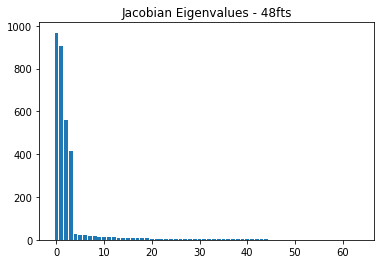

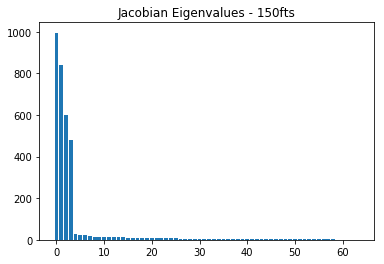

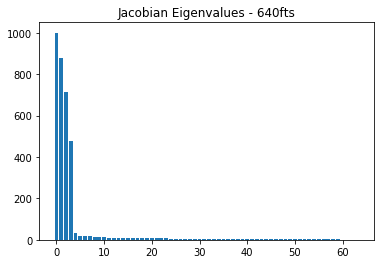

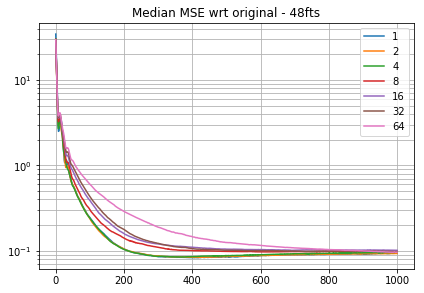

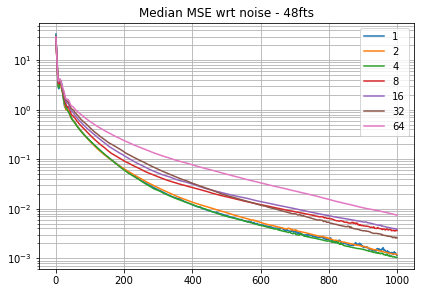

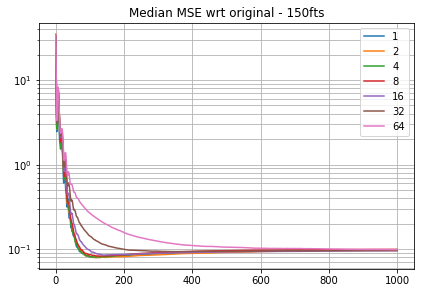

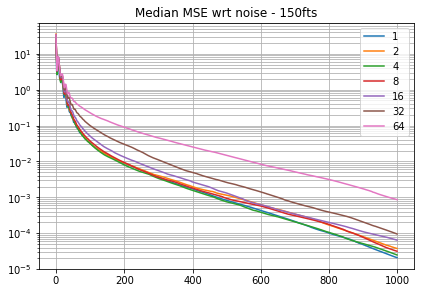

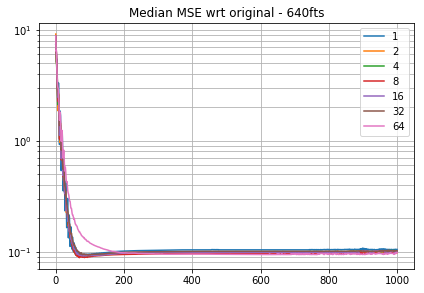

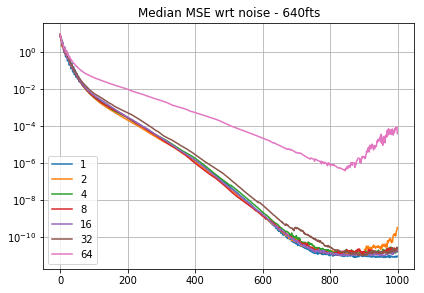

In [3]:
# Plot dec eigenvalues
for i, exp in enumerate(exps):
    plt.figure()
    plt.bar(range(G.N), exp['Lambda'])
    plt.title('Jacobian Eigenvalues - {}fts'.format(exp['fts']))

# Plots Median Error
for i, exp in enumerate(exps):
    med_mse = np.median(np.sum(err[i, :], axis=3), axis=1)
    plt.figure()
    plt.semilogy(med_mse.T)
    plt.grid(True, which='both')
    plt.legend(params)
    plt.title('Median MSE wrt original - {}fts'.format(exp['fts']))
    plt.tight_layout()

    med_mse_n = np.median(np.sum(err_wrt_n[i, :], axis=3), axis=1)
    plt.figure()
    plt.semilogy(med_mse_n.T)
    plt.grid(True, which='both')
    plt.legend(params)
    plt.title('Median MSE wrt noise - {}fts'.format(exp['fts']))
    plt.tight_layout()

In [4]:
plt.show()